In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv",index_col=0)

In [3]:
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
data["Date"]=pd.to_datetime(data[["year","month","day","hour"]])

In [5]:
data.drop(["year","month","day","hour"],axis=1,inplace=True)
data.set_index("Date",inplace=True)

In [6]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
min(data.index)

Timestamp('2010-01-01 00:00:00')

In [8]:
max(data.index)

Timestamp('2014-12-31 23:00:00')

In [9]:
data.isnull().sum(axis=0)

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [10]:
from sklearn.impute import SimpleImputer

data["pm2.5"]=SimpleImputer(strategy="mean").fit_transform(data[["pm2.5"]])

In [11]:
data.to_csv("pollution.csv")

In [12]:
data=pd.read_csv("pollution.csv",index_col="Date",parse_dates=True)

In [13]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


In [14]:
#graficamos los datos sobre series temporales
data["cbwd"].value_counts()

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

In [15]:
def plot_series(data):
    plt.figure(figsize=(10,10))
    for i,column in enumerate(data.columns):
        plt.subplot(len(data.columns),1,i+1)
        plt.plot(data.iloc[:,i])
        plt.title(column,loc="right")
    plt.show()

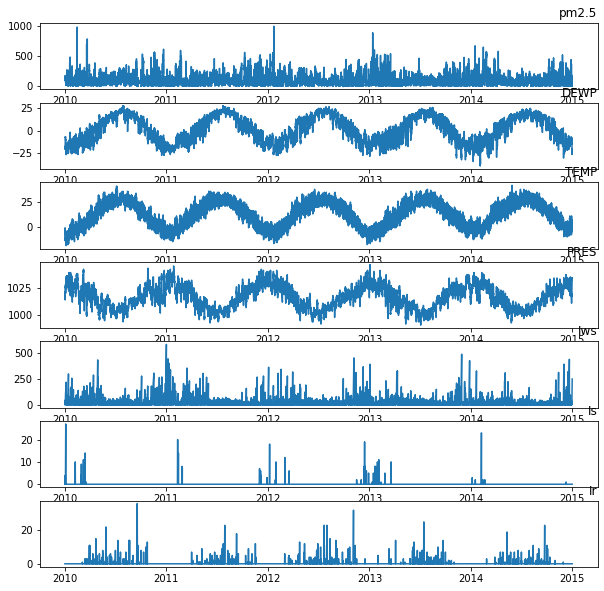

In [16]:
plot_series(data.drop("cbwd",axis=1))

In [19]:
data.sort_index(inplace=True)


In [21]:
data.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [27]:
data.index[0]

Timestamp('2010-01-01 00:00:00')

In [31]:
data.index[0]+pd.Timedelta(hours=2)

Timestamp('2010-01-01 02:00:00')

In [32]:
max(data.index)

Timestamp('2014-12-31 23:00:00')

In [37]:
#problema: predecir la presion del dia siguiente en base a la presion del dia anterior
#primero vamos a separar los datos de entrenamiento y prueba
dataset=data[["PRES"]]
train=dataset[:"2013-12-31 23:00:00"]
test=dataset["2014-01-01 00:00:00":]

In [38]:
#aplicamos el escalamiento
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
train=scaler.fit_transform(train)
test=scaler.transform(test)

In [40]:
train,test

(array([[0.54545455],
        [0.52727273],
        [0.50909091],
        ...,
        [0.41818182],
        [0.41818182],
        [0.41818182]]),
 array([[0.41818182],
        [0.4       ],
        [0.4       ],
        ...,
        [0.78181818],
        [0.78181818],
        [0.78181818]]))

In [56]:
def create_dataset(data,n_steps=1):
    X,y=[],[]
    for i in range(n_steps,len(data)):
        X.append(data[i-n_steps:i,0]) #puedo hacer una indexacion elegante con [0] y ahorrar el reshape(x.shape[0],x.shape[1],1)
        y.append(data[i,0])
    return np.array(X),np.array(y)
    

In [65]:
n_steps=24 #se predicira elvalor de la presion siguiente en base a las presiones del dia anterior (24 past)
x_train,y_train=create_dataset(train,n_steps)
x_test,y_test=create_dataset(test,n_steps)

In [66]:
x_train.shape, x_test.shape

((35040, 24), (8736, 24))

In [67]:
#remodelamiento de datos para (samples,time_step,features) con una sola feature=1

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [68]:
x_train.shape, x_test.shape

((35040, 24, 1), (8736, 24, 1))

In [69]:
y_train.shape,y_test.shape

((35040,), (8736,))

In [71]:
#creacion del modelo de redes neuronales
import tensorflow as tf
from keras.utils import plot_model

In [91]:
entry_shape=(x_train.shape[1],1)
def build_model():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=entry_shape,name="INPUT"))
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,name="LSTM_64"))
    model.add(tf.keras.layers.Dropout(0.25,name="DROPOUT_1"))
    model.add(tf.keras.layers.LSTM(units=32,name="LSTM_32"))
    model.add(tf.keras.layers.Dropout(0.25,name="DROPOUT_2"))
    model.add(tf.keras.layers.Dense(1,name="OUTPUT"))
    #ahora la compilacion del modelo
    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"]
                 )
    return model

In [96]:
model_lstm=build_model()


In [93]:
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_64 (LSTM)               (None, 24, 64)            16896     
_________________________________________________________________
DROPOUT_1 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
LSTM_32 (LSTM)               (None, 32)                12416     
_________________________________________________________________
DROPOUT_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


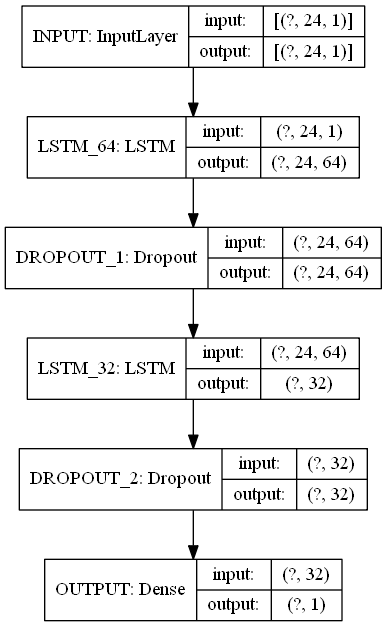

In [94]:
plot_model(model_lstm,show_shapes=True)

In [98]:
model_lstm.fit(x_train,y_train,epochs=10,batch_size=128)

Epoch 1/10
274/274 [==============================] - 16s 60ms/step - loss: 0.0012 - mae: 0.0251
Epoch 2/10
274/274 [==============================] - 17s 63ms/step - loss: 0.0010 - mae: 0.0231
Epoch 3/10
274/274 [==============================] - 17s 61ms/step - loss: 8.6215e-04 - mae: 0.0216
Epoch 4/10
274/274 [==============================] - 16s 60ms/step - loss: 7.8132e-04 - mae: 0.0207
Epoch 5/10
274/274 [==============================] - 17s 61ms/step - loss: 7.3544e-04 - mae: 0.0202
Epoch 6/10
274/274 [==============================] - 17s 60ms/step - loss: 6.9861e-04 - mae: 0.0197
Epoch 7/10
274/274 [==============================] - 16s 60ms/step - loss: 6.8374e-04 - mae: 0.0195
Epoch 8/10
274/274 [==============================] - 17s 61ms/step - loss: 6.7343e-04 - mae: 0.0193
Epoch 9/10
274/274 [==============================] - 16s 60ms/step - loss: 6.8323e-04 - mae: 0.0195
Epoch 10/10
274/274 [==============================] - 16s 59ms/step - loss: 6.6000e-04 - mae: 0.01

In [99]:
history=_

In [102]:
model_lstm.evaluate(x_test,y_test)

273/273 [==============================] - 3s 10ms/step - loss: 2.8224e-04 - mae: 0.0141


[0.00028223550179973245, 0.01412209402769804]

In [112]:
y_pred=model_lstm.predict(x_test)

In [117]:
def plot_series(y_true,y_pred):
    plt.figure(figsize=(30,7))
    plt.plot(y_true,color="green",label="Y true")
    plt.plot(y_pred,color="red", label="Y predict")
    plt.legend(loc="best")
    plt.show()

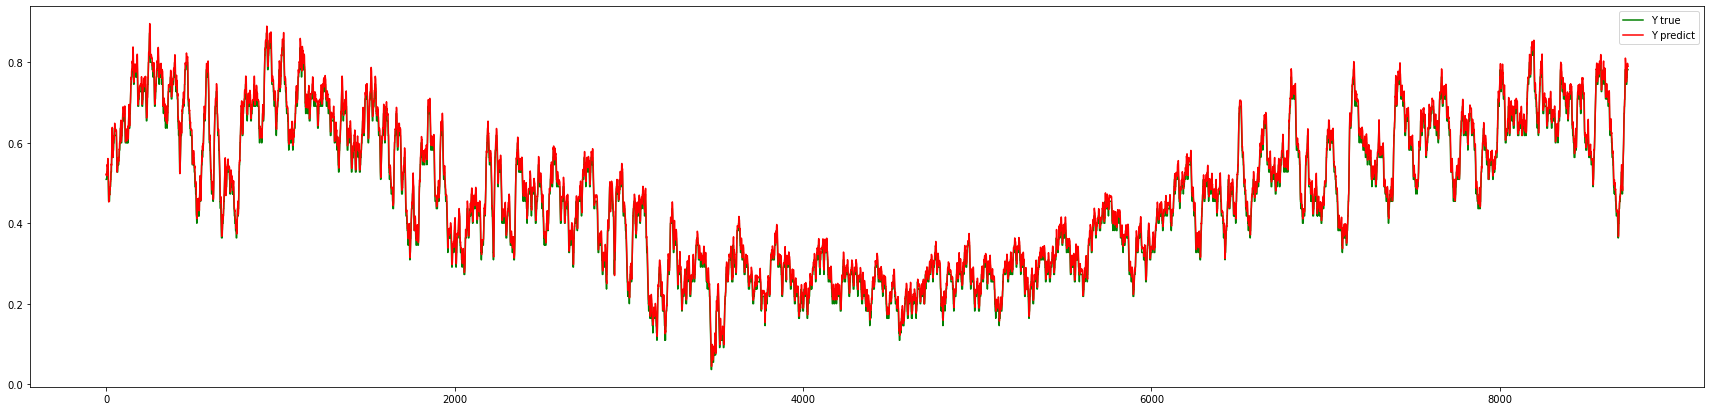

In [118]:
plot_series(y_test,y_pred)

In [133]:
result=pd.DataFrame({
    "Y true":scaler.inverse_transform(y_test[np.newaxis,:]).flatten(),
    "Y pred":scaler.inverse_transform(y_pred).flatten()
})

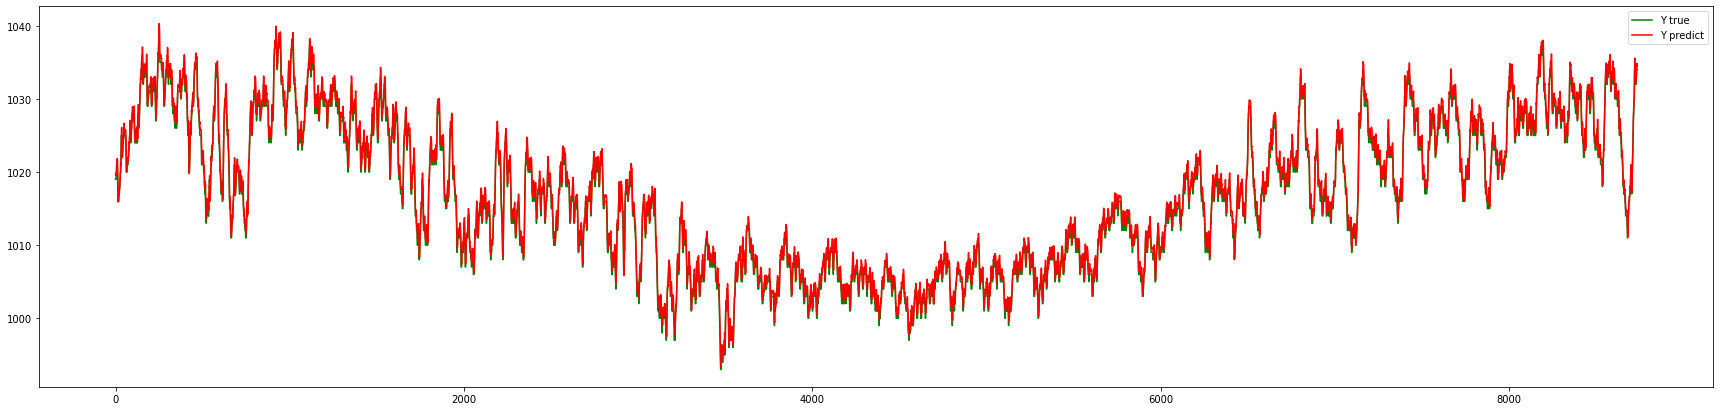

In [134]:
plot_series(result["Y true"],result["Y pred"])

In [135]:
#guardamos el modelo
model_lstm.save("model_lstm_predict_PRES")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_lstm_predict_PRES\assets
